# Appendix

Things that don't go in the main notebook but are important to show how we got there.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

import data as d
from get_sm_for_sim import get_sm_for_sim, get_smf
import smhm_fit
import plots as p
import clustering as c
import likelihood as l

import halotools.empirical_models
import halotools.sim_manager

from multiprocessing import Pool
%run ~/.jupyter/config.ipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# A: Initial coords for Vmax@Mpeak

Per conversation with Peter, we should be getting stellar mass not from halo mass (or Mpeak) but rather from Vmax@Mpeak. I think this is because halo mass starts to become stripped much earlier than circular velocity reduces. Therefore when getting stellar masses from Vmax, halos that are close to each other will have higher (an more accurate) masses than if we got using their mass.

How to get starting coords though?

We know some good coords using stellar mass. We can generate a reasonable estimate of the stellar masses using those.
We can then plot this SM as a function of halo mass and Vmax. We then generate estimates of SM using the model and the parameters. If the data and the model agree the starting params are good.

In [4]:
sim_data, sim_size = d.load_mdpl()

In [5]:
# Starting params from https://arxiv.org/pdf/1104.0928.pdf
# m1, sm0, beta, delta, gamma
mass_b_params = [12.52, 10.91, 0.45, 0.6, 1.83]
mass_s_params = [-0.06, 1.08]
mass_x_field = "halo_mvir"
# best_fit = [12.46178498, 10.87987102,  0.45690214,  0.636816,    1.87057079, -0.0614553,   1.07878507]

# sm0 and beta shouldn't change
# m1 we just set to be roughly the vmax equivalent
# the delta and gamma slopes we iterated on (i.e. change them, run next cell) until finding a decent start
vmax_b_params = [2.4, 10.91, 0.45, 0.3, 0.2]
#vmax_b_params = [4.4, 10.91, 0.45, 0.49, 2.7]

# These are pretty easy to get just by looking at the plots (should be ~0.3 at the lowest vmax and ~0.15 at the highest)
vmax_s_params = [-0.1, 0.5]
vmax_x_field = "Vmax@Mpeak"

In [86]:
if False:
    mass_b_params = [12.52, 10.91, 0.45, 0.6, 1.83]
    mass_s_params = [-0.06, 1.08]
    log_stellar_masses = get_sm_for_sim(sim_data, mass_b_params, mass_s_params, mass_x_field)
else:
    vmax_b_params = [2.4, 10.91, 0, 0.4, 0.6]#[ 2.37998488, 10.92042303,  0.55623719,  0.18581664,  0.27877097]
    vmax_s_params = [-0.11090357,  0.51954824]
    log_stellar_masses = get_sm_for_sim(sim_data, vmax_b_params, vmax_s_params, vmax_x_field)

(<Figure size 1200x800 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fae8842cc88>)

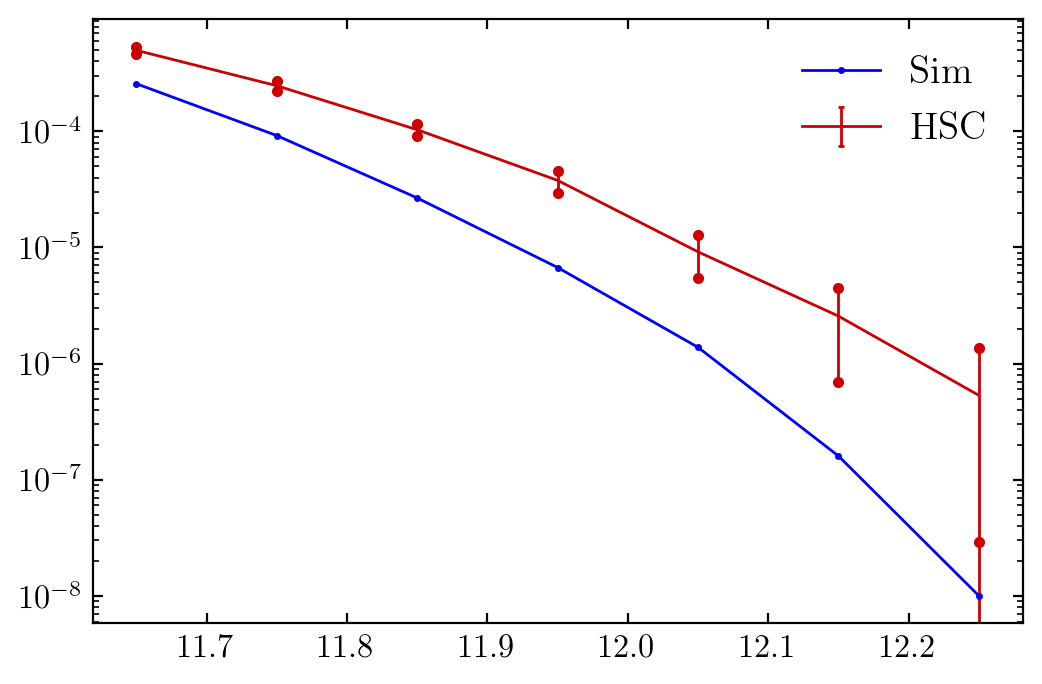

In [87]:
obs_smf = d.load_smf()
p.plot_smfs(obs_smf, log_stellar_masses, 1000)

In [43]:
# First, the vmax-mhalo relation.
vmax, mhalo, _ = scipy.stats.binned_statistic(np.log10(sim_data[mass_x_field]), np.log10(sim_data[vmax_x_field]), np.mean, bins = 12)
mhalo = (mhalo[1:] + mhalo[:-1])/2

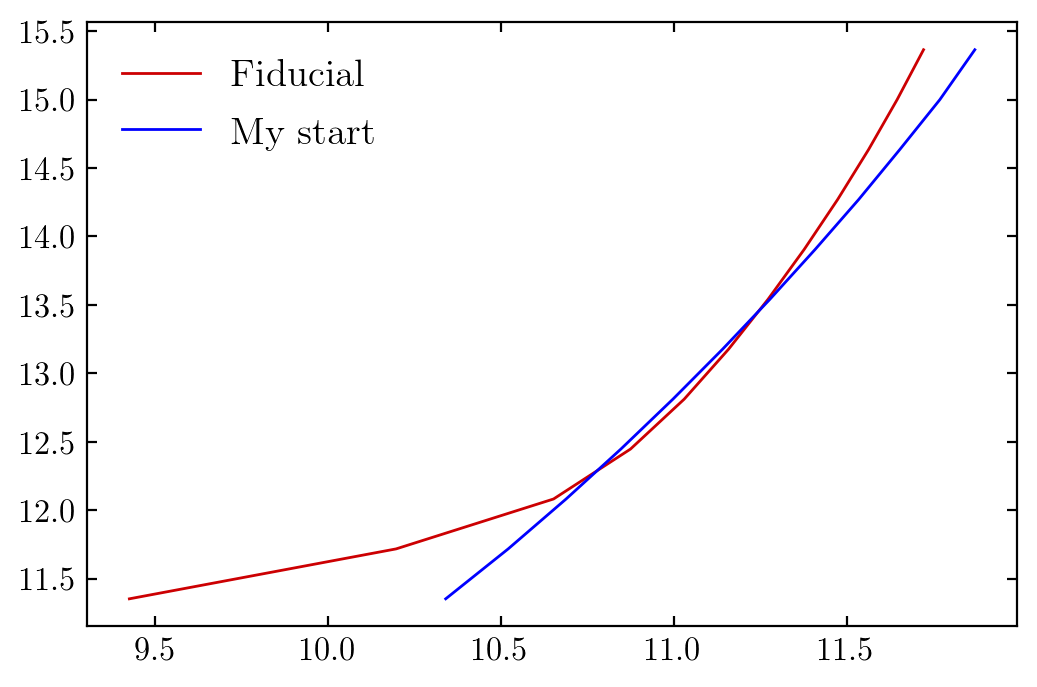

In [111]:
_, ax = plt.subplots()
vmax_b_params = [2.4, 10.91, 0.35, 0.2, 0.3]

# Now the fiducial sm-hm relation with Alexie's fit.
lsm1 = get_sm_for_sim((10**mhalo).view([("this_field", "f8")]), mass_b_params, [0, 0], "this_field")
ax.plot(lsm1, mhalo, label="Fiducial")

# Now the proposed start position
lsm2 = get_sm_for_sim((10**vmax).view([("this_field", "f8")]), vmax_b_params, [0, 0], "this_field")
ax.plot(lsm2, mhalo, label="My start")
ax.legend()

# B: Sanity check we are converting masses to /h correctly

17.415844702499612 15.625


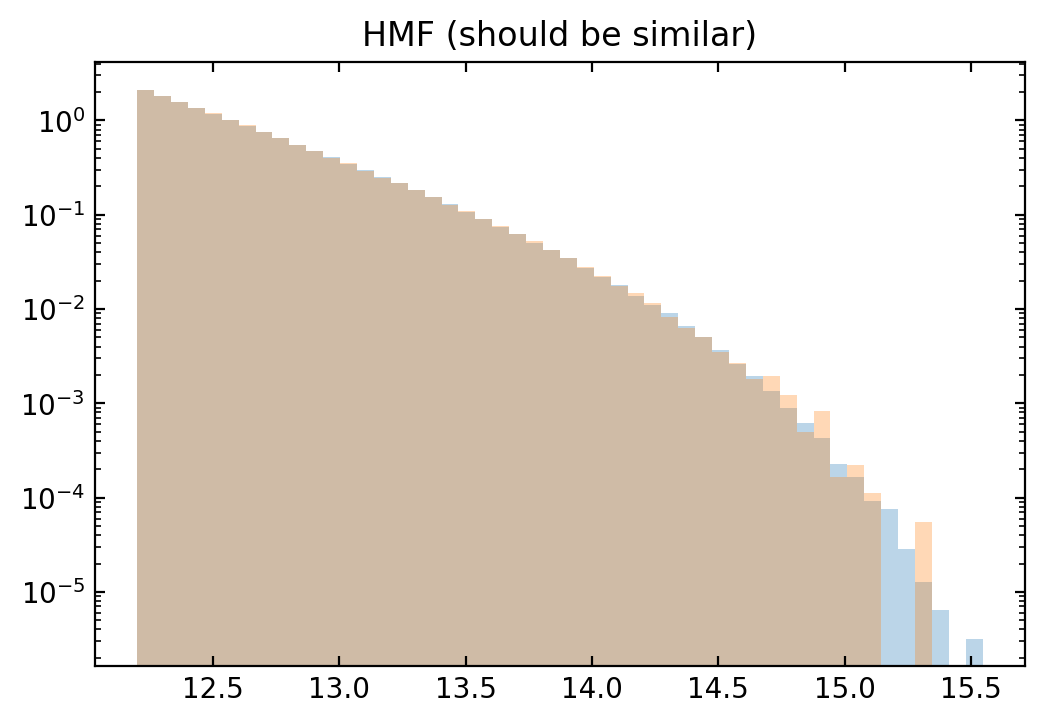

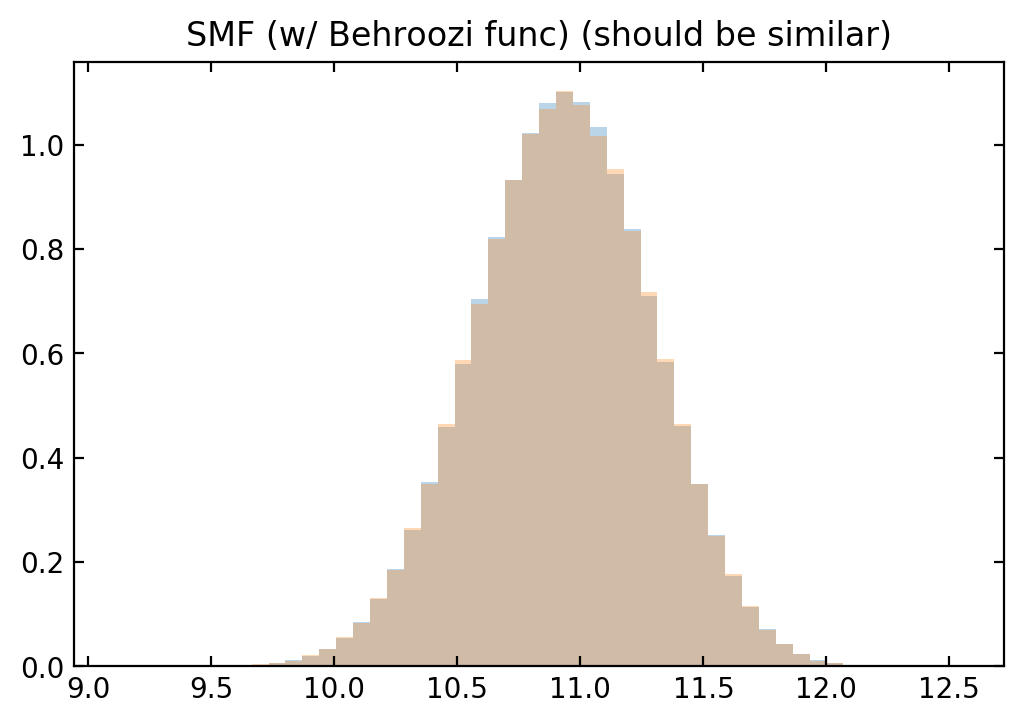

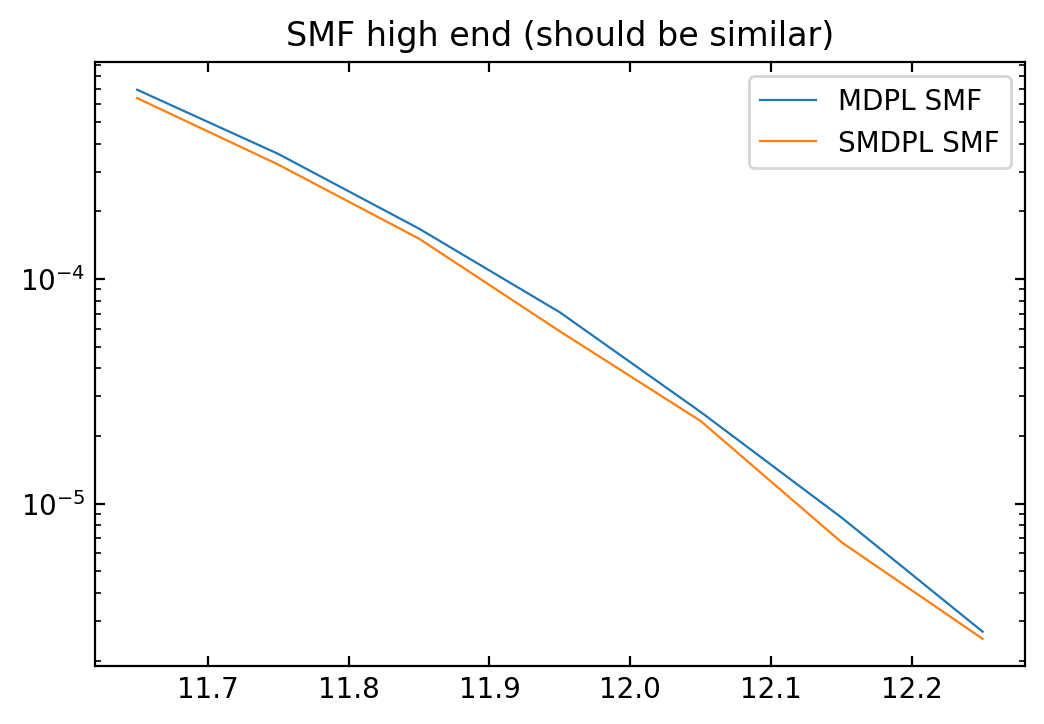

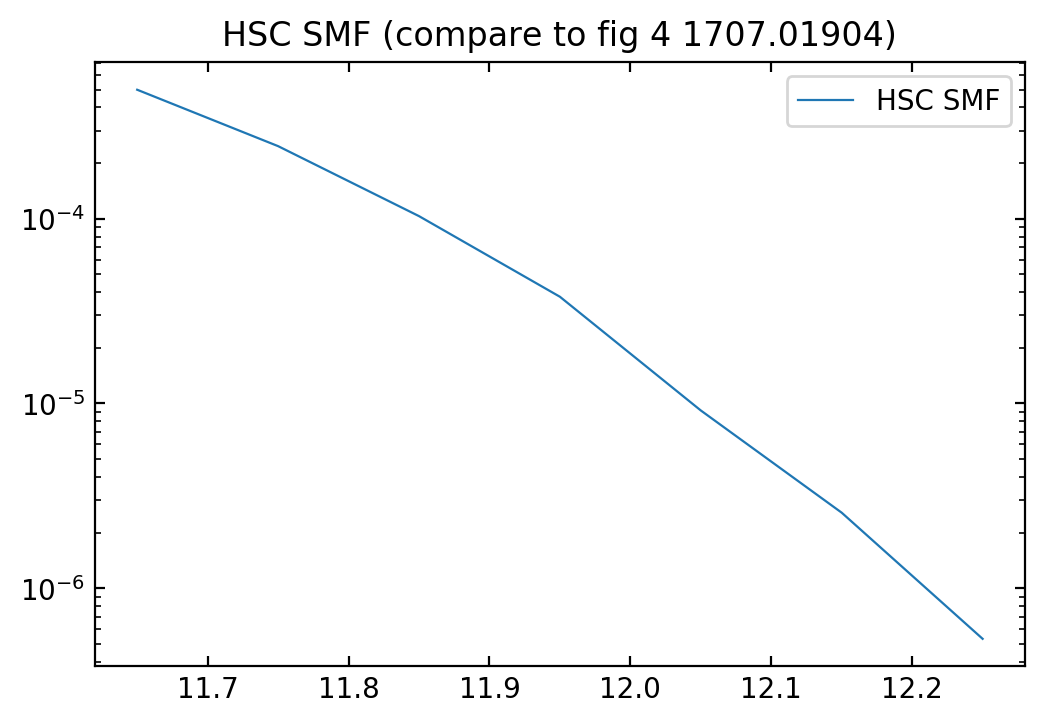

In [33]:
mdpl, mdpl_size = d.load_mdpl()
smdpl, smdpl_size = d.load_smdpl()
obs_smf = d.load_smf()

# Halo masses should be similar in smdpl and mdpl
_, ax = plt.subplots()
_, bins, _ = ax.hist(np.log10(mdpl["halo_mvir"]), bins=50, density=True, alpha=0.3)
ax.hist(np.log10(smdpl["halo_mvir"]), bins=bins, density=True, alpha=0.3)
ax.set(yscale="log", title="HMF (should be similar)")

# Stellar masses should be similar
mass_b_params = [12.52, 10.91, 0.45, 0.6, 1.83]
mass_s_params = [-0.06, 1.08]
mass_x_field = "halo_mvir"
mdpl_sm = get_sm_for_sim(mdpl, mass_b_params, mass_s_params, mass_x_field)
smdpl_sm = get_sm_for_sim(smdpl, mass_b_params, mass_s_params, mass_x_field)

_, ax = plt.subplots()
_, bins, _ = ax.hist(mdpl_sm, bins=50, density=True, alpha=0.3)
ax.hist(smdpl_sm, bins=bins, density=True, alpha=0.3)
ax.set(title="SMF (w/ Behroozi func) (should be similar)")

# The SMF should be similar
sm_bins = np.linspace(11.6, 12.3, 8)
sm_bin_centers = (sm_bins[:-1] + sm_bins[1:]) / 2

_, ax = plt.subplots()
ax.plot(sm_bin_centers, get_smf(mdpl_sm, sm_bins, mdpl_size**3), label = "MDPL SMF")
ax.plot(sm_bin_centers, get_smf(smdpl_sm, sm_bins, smdpl_size**3), label="SMDPL SMF")
ax.set(yscale="log", title="SMF high end (should be similar)")
ax.legend()

# The ratio of the number of galaxies should be similar to the ratio of volumes
print(len(mdpl) / len(smdpl), mdpl_size**3 / smdpl_size**3)

# Smf should be quite a bit larger than 1e-4 at 11.6 (different to fig 4 https://arxiv.org/pdf/1707.01904.pdf)
_, ax = plt.subplots()
plt.plot(obs_smf["logm_mean"], obs_smf["smf"], label="HSC SMF")
ax.set(yscale="log", title="HSC SMF (compare to fig 4 1707.01904)")
ax.legend()

# C: Speed up convergence

The only significant components
```
ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      661    2.836    0.004    2.836    0.004 {method 'sort' of 'numpy.ndarray' objects}
        1    1.935    1.935    1.938    1.938 {method 'normal' of 'mtrand.RandomState' objects}
        1    1.726    1.726    5.333    5.333 get_sm_for_sim.py:10(get_sm_for_sim)
        1    1.630    1.630    1.630    1.630 {built-in method numpy.core.multiarray.interp}
        3    1.327    0.442    1.327    0.442 {built-in method Corrfunc._countpairs.countpairs_rp_pi}
        3    1.102    0.367    2.438    0.813 clustering.py:18(compute_sim_clustering)
```

In [25]:
# Copy this from the first section in main (load + initial config)
best_fit = [ 2.37998488, 10.92042303,  0.35623719,  0.18581664,  0.27877097, -0.11090357,  0.51954824]
cen_sat_div = [11.65, 11.75, 11.85]
sim_data, sim_size = d.load_mdpl()

hsc_gals = d.load_hsc_gals()
obs_clust = np.array(
    [c.compute_hsc_clustering(hsc_gals, div) for div in cen_sat_div],
    dtype=[("clustering", np.float64), ("err", np.float64)])
obs_smf = d.load_smf()

x_field = "Vmax@Mpeak"

[Memory]396.9s, 6.6min  : Loading compute_hsc_clustering...
[Memory]396.9s, 6.6min  : Loading compute_hsc_clustering...
[Memory]396.9s, 6.6min  : Loading compute_hsc_clustering...


In [27]:
def f(params):
    return l.compute_chi2(params, sim_data, obs_smf, obs_clust, sim_size, cen_sat_div, x_field)

inp = [best_fit.copy() for i in range(6)]
inp[0][0] *= 1.01

with Pool(6) as p:
    res = p.map(f, inp)
print(res)

[22.421916695717286, 2.069683888373347, 2.069683888373347, 2.069683888373347, 2.069683888373347, 2.069683888373347]


In [15]:
%%prun
l.compute_chi2(best_fit, sim_data, obs_smf, obs_clust, sim_size, cen_sat_div, x_field)

# D: get_sm_for_sim actually does what it should 

Generates masses that are ~ correct and scatter that is fully correct.

## Toy model

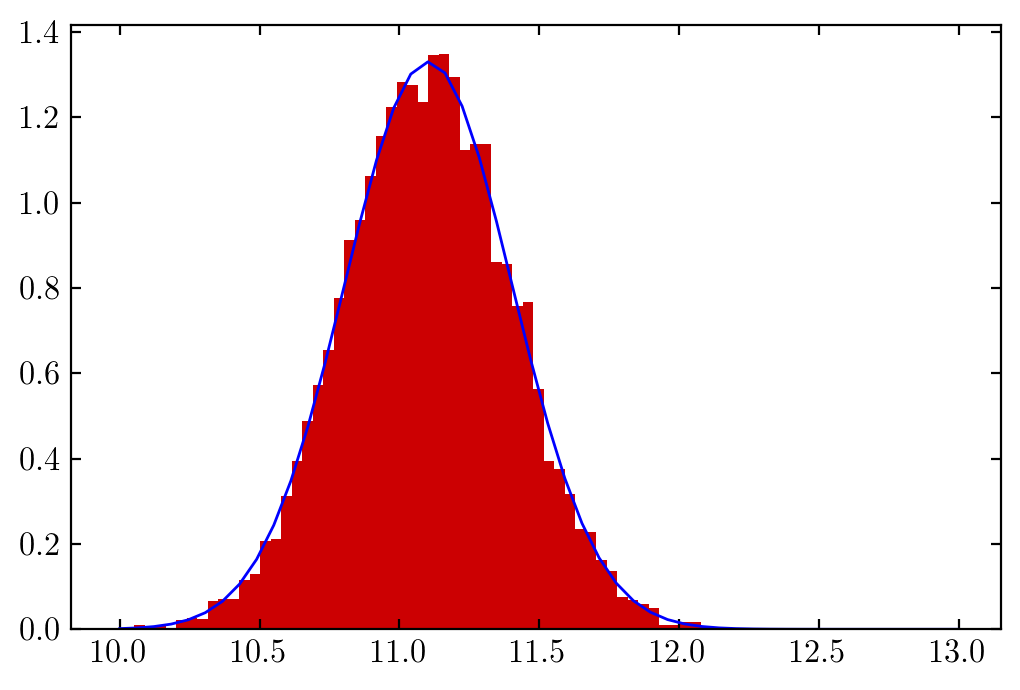

In [62]:
mass_b_params = [12.52, 10.91, 0.45, 0.6, 1.83]
mass_s_params = [-0.06, 1.08]

hm = 1e13
sim = halotools.sim_manager.FakeSim(num_massbins=1, num_halos_per_massbin=10000)
sim.halo_table["halo_mvir"] = hm

log_stellar_masses = get_sm_for_sim(sim.halo_table, mass_b_params, mass_s_params, "halo_mvir")
_, ax = plt.subplots()
ax.hist(log_stellar_masses, bins="fd", density=True)

# The stellar mass should be a lognormal with the mean and scatter based on the hm
ssm = np.linspace(10, 13)
ax.plot(ssm, 
        scipy.stats.norm(loc = np.mean(log_stellar_masses), scale = mass_s_params[1] + mass_s_params[0]*np.log10(hm)).pdf(ssm)
       )

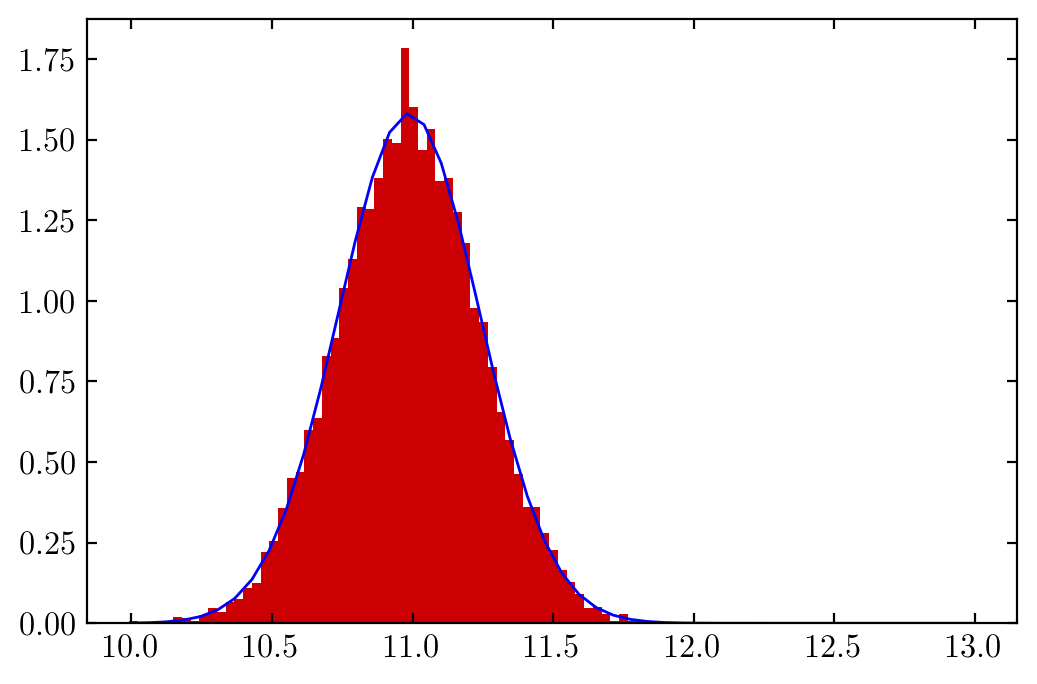

In [63]:
vmax_b_params = [2.4, 10.91, 0.45, 0.3, 0.2]
vmax_s_params = [-0.1, 0.5]

vm = 300
sim = halotools.sim_manager.FakeSim(num_massbins=1, num_halos_per_massbin=10000)
sim.halo_table["halo_vpeak"] = vm

log_stellar_masses = get_sm_for_sim(sim.halo_table, vmax_b_params, vmax_s_params, "halo_vpeak")
_, ax = plt.subplots()
ax.hist(log_stellar_masses, bins="fd", density=True)

ssm = np.linspace(10, 13)
ax.plot(ssm, 
        scipy.stats.norm(loc = np.mean(log_stellar_masses), scale = vmax_s_params[1] + vmax_s_params[0]*np.log10(vm)).pdf(ssm)
       )

## Full model

In [ ]:
vmax_b_params = [2.4, 10.91, 0.45, 0.3, 0.2]
vmax_s_params = [-0.1, 0.5]

sim_data, sim_size = d.load_mdpl()

In [51]:
log_stellar_masses = get_sm_for_sim(sim_data, vmax_b_params, vmax_s_params, "Vmax@Mpeak")

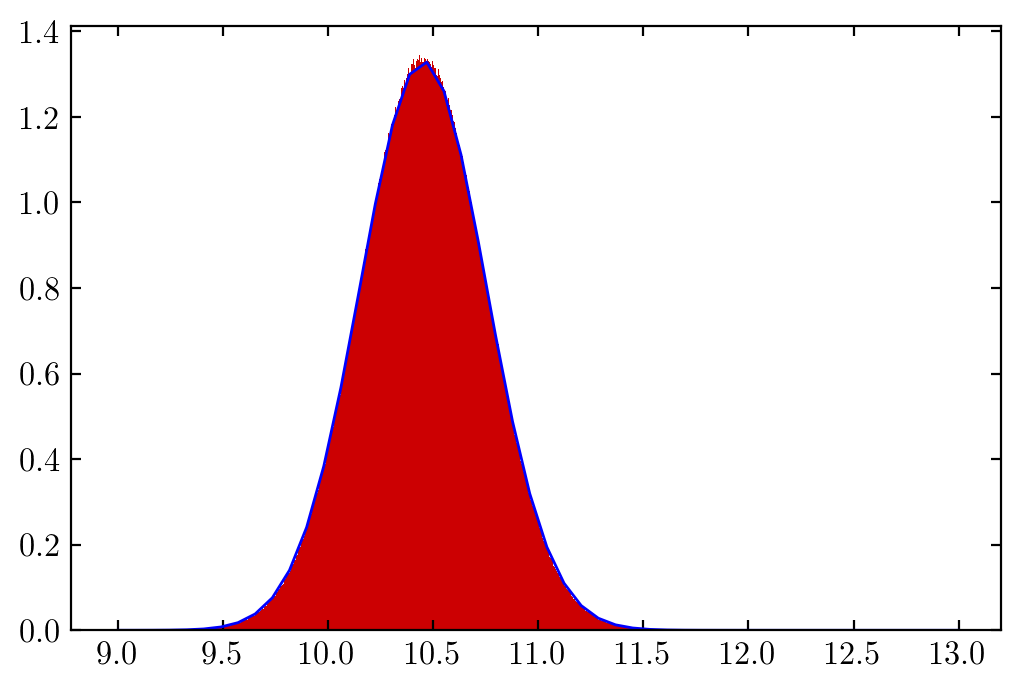

In [58]:
cut = (sim_data["Vmax@Mpeak"] > 100) & (sim_data["Vmax@Mpeak"] < 110)
_, ax = plt.subplots()
ax.hist(log_stellar_masses[cut], density=True)

ssm = np.linspace(9, 13)
ax.plot(ssm, 
        scipy.stats.norm(loc = np.mean(log_stellar_masses[cut]), scale = vmax_s_params[1] + vmax_s_params[0]*np.log10(100)).pdf(ssm)
       )

# D: Comparison HaloTools

Not sure how the HaloTools Models work...

It looks like you create a `SubhaloModelFactory` and when creating that pass a bunch of models that are able to get galaxy properties.

An example model is the [Behroozi10](https://arxiv.org/abs/1001.0015) SM-HM relation. This can be constructed with `Behroozi10SmHm` but it looks like while that allows the user to pass scatter params, the actual params are locked to the best fit from that model. It also locks the user to building a model based on halo mass.

There is also a Behroozi10 model which is different - see [https://halotools.readthedocs.io/en/latest/api/halotools.empirical_models.Behroozi10SmHm.html#halotools.empirical_models.Behroozi10SmHm](here). But it later goes on to say that the model is just the `SmHm` at a fixed redshift.

In [26]:
halocat = halotools.sim_manager.FakeSim(num_halos_per_massbin=1)

test_b_params = [12.35/0.7, 10.72/0.7, 0.43, 0.56, 1.54] # These are the params from the Behroozi best fit.
test_s_params = [0, 0]

get_sm_for_sim(halocat.halo_table, test_b_params, test_s_params, "halo_mvir")

array([ 5.        ,  5.        ,  5.        ,  5.        ,  5.        ,  6.45492802,  8.00531561,  9.55570321, 11.10609081, 12.65647231])

In [24]:
model = halotools.empirical_models.SubhaloModelFactory(
    sm = halotools.empirical_models.Behroozi10SmHm(redshift = 0, scatter_abscissa = 12, scatter_ordinates = 0),
)

model.populate_mock(halocat)
print(np.log10(model.mock.galaxy_table["stellar_mass"]))

# This is different to my code (when my code uses the same behroozi params) because:
# in halotools, all masses are with h=1, but the behroozi params are with h=0.7 (and the masses are converted there and back in the calculation)
# in my code, masses can be with any h and the behroozi params will be with the same h.

# To confirm that this is the only difference, comment out the references to littleh in 
# halotools/empirical_models/smhm_models/behroozi10.py:mean_log_halo_mass

stellar_mass
------------
    6.470331
    8.018849
    9.536242
   10.300988
   10.617044
   10.847518
   11.039788
   11.204988
  11.3478565
   11.472729
